In [29]:
using CUDA
using Images
using FileIO
using ArrayPadding

┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   Base.PkgId(Base.UUID("1285c0f1-ff9f-5867-b66e-0f359bcf09ba"), "SpecialFunctionsExt")
│   Base.PkgId(Base.UUID("06e1c1a7-607b-532d-9fad-de7d9aa2abac"), "TiledIteration")
│   Base.PkgId(Base.UUID("0d7ed370-da01-4f52-bd93-41d350b8b718"), "StaticArrayInterface")
│   Base.PkgId(Base.UUID("63c18a36-062a-441e-b654-da1e3ab1ce7c"), "KernelAbstractions")
│   Base.PkgId(Base.UUID("bdcacae8-1622-11e9-2a5c-532679323890"), "LoopVectorization")
│   Base.PkgId(Base.UUID("f78586ac-ba87-5ec7-b3a5-84bc1b258ee3"), "ArrayInterfaceCUDAExt")
│   Base.PkgId(Base.UUID("51556ac3-7006-55f5-8cb3-34580c88182d"), "ImageDistances")
│   Base.PkgId(Base.UUID("476501e8-09a2-5ece-8869-fb82de89a1fa"), "SLEEFPirates")
│   Base.PkgId(Base.UUID("6a3955dd-da59-5b1f-98d4-e7296123deb5"), "ImageFiltering")
│   Base.PkgId(Base.UUID("fb6a15b2-703c-40df-9091-08a04967cfa9"), "CloseOpenIntervals")
│   Base.PkgId(Base.UUID("3da70926-fe1b-5635-95a0-8ca47c

In [2]:
function grayscott_reaction_kernel!(du, dv, u, v, f, k)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    
    if i <= size(du, 1) && j <= size(du, 2)
        uv = u[i,j] * v[i,j]^2
        @inbounds du[i,j] += -uv + f * (1.0 - u[i,j])
        @inbounds dv[i,j] += uv - (f + k[i,j]) * v[i,j]
    end
    return nothing
end

grayscott_reaction_kernel! (generic function with 1 method)

In [3]:
function grayscott_reaction!(du, dv, u, v, f, k)
    threads = (16, 16)
    blocks = ceil.(Int, size(du) ./ threads)
    @cuda blocks=blocks threads=threads grayscott_reaction_kernel!(du, dv, u, v, f, k)
end

grayscott_reaction! (generic function with 1 method)

In [4]:
function diffuse_kernel!(du, u, D)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    
    if 2 <= i < size(du, 1) && 2 <= j < size(du, 2)
        tmp = 0.0f0
        @inbounds begin
            tmp += 0.05f0*u[i-1,j-1] + 0.2f0*u[i,j-1] + 0.05f0*u[i+1,j-1]
            tmp += 0.2f0*u[i-1,j] - 1.0f0*u[i,j] + 0.2f0*u[i+1,j]
            tmp += 0.05f0*u[i-1,j+1] + 0.2f0*u[i,j+1] + 0.05f0*u[i+1,j+1]
            du[i,j] += D * tmp
        end
    end
    return nothing
end

diffuse_kernel! (generic function with 1 method)

In [5]:
function diffuse!(du, u, D)
    threads = (16, 16)
    blocks = ceil.(Int, size(du) ./ threads)
    @cuda blocks=blocks threads=threads diffuse_kernel!(du, u, D)
end

diffuse! (generic function with 1 method)

In [6]:
function clamp01_kernel!(x)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    j = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    
    if i <= size(x, 1) && j <= size(x, 2)
        @inbounds x[i,j] = clamp(x[i,j], 0.0f0, 1.0f0)
    end
    return nothing
end

clamp01_kernel! (generic function with 1 method)

In [7]:
function clamp01!(x)
    threads = (16, 16)
    blocks = ceil.(Int, size(x) ./ threads)
    @cuda blocks=blocks threads=threads clamp01_kernel!(x)
end

clamp01! (generic function with 1 method)

In [18]:
function forced_grayscott(img; f=0.0347f0, k=0.057f0, D_u=0.4f0, D_v=0.06f0, tmax=10, h=0.05f0)
    # Convert input to CuArray and ensure Float32
    vals = Float32.(img)
    u = CuArray(copy(vals))
    v = CuArray(1f0 .- vals)
    k = CuArray(k)
    #k = fill(k, size(vals)) |> CuArray  # Convert k to matrix if it's not already
    
    du = CUDA.zeros(Float32, size(vals))
    dv = CUDA.zeros(Float32, size(vals))
    
    for t in 1:tmax
        CUDA.fill!(du, 0f0)
        CUDA.fill!(dv, 0f0)
        
        grayscott_reaction!(du, dv, u, v, f, k)
        diffuse!(du, u, D_u)
        diffuse!(dv, v, D_v)
        
        u .+= h .* du
        v .+= h .* dv
        
        clamp01!(u)
        clamp01!(v)
    end
    
    return Array(u), Array(v)  # Convert back to CPU arrays
end

forced_grayscott (generic function with 1 method)

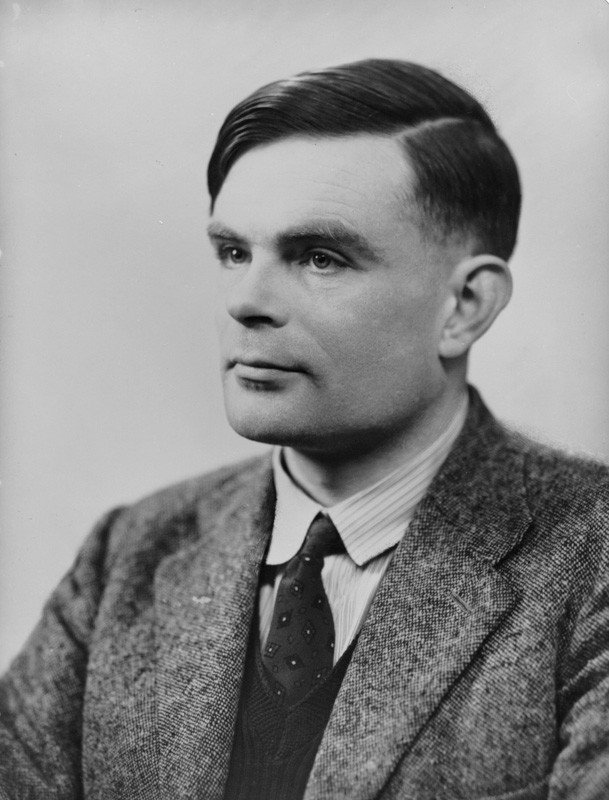

In [12]:
img_turing = Gray.(load("Turing.jpg"))


In [31]:
vals = pad(Float32.(img_turing), 0f0, (1,1))

802×611 Matrix{Float32}:
 0.0  0.0       0.0       0.0       …  0.0       0.0       0.0       0.0
 0.0  0.67451   0.690196  0.694118     0.862745  0.984314  0.992157  0.0
 0.0  0.670588  0.686275  0.690196     0.572549  0.878431  0.992157  0.0
 0.0  0.666667  0.678431  0.686275     0.819608  0.623529  0.866667  0.0
 0.0  0.670588  0.678431  0.686275     0.815686  0.72549   0.662745  0.0
 0.0  0.678431  0.682353  0.690196  …  0.72549   0.819608  0.741176  0.0
 0.0  0.686275  0.686275  0.694118     0.854902  0.737255  0.784314  0.0
 0.0  0.690196  0.690196  0.698039     0.768627  0.803922  0.764706  0.0
 0.0  0.694118  0.690196  0.698039     0.8       0.772549  0.776471  0.0
 0.0  0.698039  0.690196  0.698039     0.776471  0.776471  0.780392  0.0
 ⋮                                  ⋱                                ⋮
 0.0  0.239216  0.286275  0.313726     0.337255  0.321569  0.309804  0.0
 0.0  0.298039  0.278431  0.341176     0.313726  0.301961  0.298039  0.0
 0.0  0.380392  0.254902  0.

In [32]:
begin
	#D_scale = 0.01
	#D_ratio = 8.0
	D_u = 0.38f0 #D_ratio * D_scale
	D_v = 0.0999f0#D_scale / D_ratio
	
	#k_min = 0.0045
	k_min = 0.015f0
	#k_max = 0.075
	k_max = 0.105f0
	# k_ = 0.08 .* sqrt.(vals)
	#k = lerp.((vals), k_min, k_max)
	k = max.(vals .* k_max, k_min)
end

802×611 Matrix{Float32}:
 0.015  0.015      0.015      0.015      …  0.015      0.015      0.015
 0.015  0.0708235  0.0724706  0.0728824     0.103353   0.104176   0.015
 0.015  0.0704118  0.0720588  0.0724706     0.0922353  0.104176   0.015
 0.015  0.07       0.0712353  0.0720588     0.0654706  0.091      0.015
 0.015  0.0704118  0.0712353  0.0720588     0.0761765  0.0695882  0.015
 0.015  0.0712353  0.0716471  0.0724706  …  0.0860588  0.0778235  0.015
 0.015  0.0720588  0.0720588  0.0728824     0.0774118  0.0823529  0.015
 0.015  0.0724706  0.0724706  0.0732941     0.0844118  0.0802941  0.015
 0.015  0.0728824  0.0724706  0.0732941     0.0811176  0.0815294  0.015
 0.015  0.0732941  0.0724706  0.0732941     0.0815294  0.0819412  0.015
 ⋮                                       ⋱                        ⋮
 0.015  0.0251176  0.0300588  0.0329412     0.0337647  0.0325294  0.015
 0.015  0.0312941  0.0292353  0.0358235     0.0317059  0.0312941  0.015
 0.015  0.0399412  0.0267647  0.0341765  … 

In [34]:
u, v = forced_grayscott(vals, D_u=D_u, D_v=D_v, k=k, tmax=500000, h=0.5f0)

(Float32[0.07713358 0.07713358 … 0.07713358 0.07713358; 0.07713358 0.1948631 … 0.2327169 0.07713358; … ; 0.07713358 0.12555629 … 0.107807964 0.07713358; 0.07713358 0.07713358 … 0.07713358 0.07713358], Float32[0.644336 0.644336 … 0.644336 0.644336; 0.644336 0.31816405 … 0.22464846 0.644336; … ; 0.644336 0.45327964 … 0.50356495 0.644336; 0.644336 0.644336 … 0.644336 0.644336])

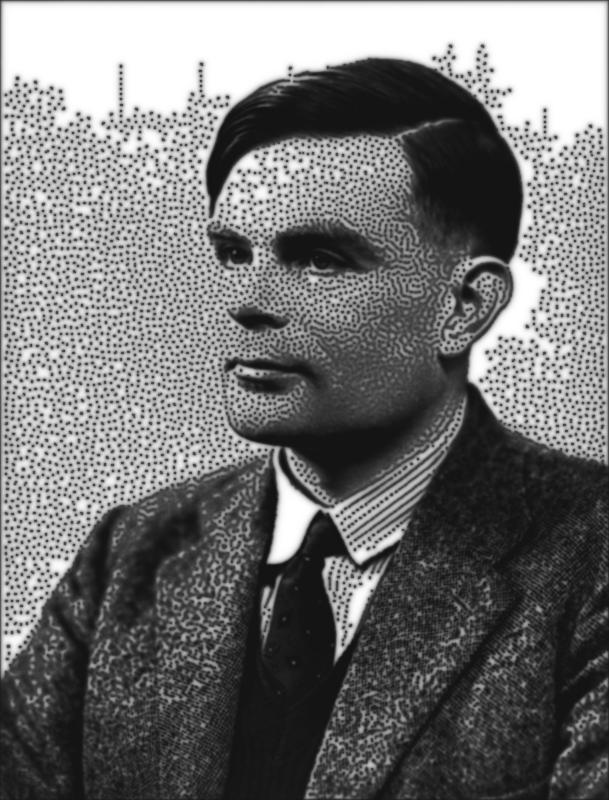

In [37]:
turing_gs = Gray.(u[2:end-1,2:end-1])

In [38]:
save("turing_gs.png", turing_gs)